# Geospatial Big Data Analytics Lab 7

Ευάγγελος Τσόγκας 03400120

Σε αυτή την εργασία θα ασχοληθούμε με Image Segmentation σε υπερφασματικές απεικονήσεις.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

## 1. SVM

Με την παρακάτω μέθοδο φορτώνω κάθε εικόνα του HyRANK dataset ξεχωριστά, την κανονικοποιώ στο [0, 1] με min-max scaling ανά band, και την απεικονίζω.

In [13]:
def load_image(img_path, gt_path=None):
    # read image
    x = imread(img_path)
    print("Image shape:", x.shape)

    # normalize image bands to [0, 1]
    band_min, band_max = np.amin(x, axis=(0, 1)), np.amax(x, axis=(0, 1))
    x = (x - band_min) / (band_max - band_min)

    # show a colored composite
    plt.figure()
    plt.title(img_path.split('/')[-1])
    plt.imshow(x[:, :, [22, 10, 6]])

    y = None
    if gt_path:
        # load ground truth
        y = imread(gt_path)
        print('Labels:', np.unique(y))

        # plot ground truth
        plt.figure()
        plt.title(gt_path.split('/')[-1])
        plt.imshow(y)

    plt.show()

    return x, y

Image shape: (249, 945, 176)
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


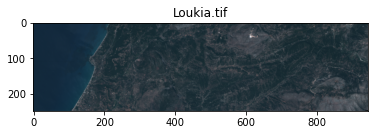

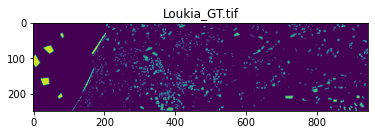

Image shape: (250, 1376, 176)
Labels: [ 0  1  2  3  4  5  7  9 10 11 12 13 14]


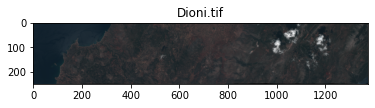

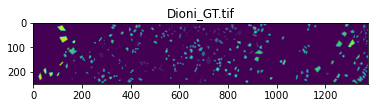

In [14]:
# load train images
loukia_x, loukia_y = load_image('HyRANK_satellite/TrainingSet/Loukia.tif', 'HyRANK_satellite/TrainingSet/Loukia_GT.tif')
dioni_x, dioni_y = load_image('HyRANK_satellite/TrainingSet/Dioni.tif', 'HyRANK_satellite/TrainingSet/Dioni_GT.tif')

Αρχικά θα εκπαιδεύσουμε ένα μοντέλο SVM κάνοντας pixel-classification για να το χρησιμοποιήσουμε σαν baseline. 

Για την εκπαίδευση τόσο του SVM όσο και της βαθιάς αρχιτεκτονικής νευρωνικού δικτύου θα χρησιμοποιήσω την εικόνα Loukia.tif και για validation την Dioni.tif. Ο λόγος είναι ότι η Loukia.tif περιέχει όλες τις κατηγορίες του dataset, ενώ από την Dioni.tif λείπουν οι κατηγορίες 6 και 8.

Για το pixel-classification στην περίπτωση του SVM κάνω flatten τις εικόνες και αφαιρώ τα pixels που δεν ανήκουν σε κάποια κατηγορία (δηλαδή έχουν label 0).

In [15]:
# train set
y_train = loukia_y.flatten()
no_class_indices = np.argwhere(y_train == 0)  # indices of pixels that don't belong to a class
y_train = np.delete(y_train, no_class_indices)

x_train = loukia_x.reshape(-1, loukia_x.shape[2])
x_train = np.delete(x_train, no_class_indices, axis=0)

# test set
y_test = dioni_y.flatten()
no_class_indices = np.argwhere(y_test == 0)
y_test = np.delete(y_test, no_class_indices)

x_test = dioni_x.reshape(-1, dioni_x.shape[2])
x_test = np.delete(x_test, no_class_indices, axis=0)

Επιλέγω RBF kernel, καθώς εμπειρικά είναι αρκετά καλός και κάνω tune την παράμετρο C για regularization με cross-validation.

In [16]:
# gridsearch
model = SVC(C=1.0, kernel='rbf', random_state=0)
parameters = {'C': [1, 10, 100, 1000]}
model_cv = GridSearchCV(model, parameters, cv=5, n_jobs=5)
model_cv.fit(x_train, y_train)

print(model_cv.best_score_)
print(model_cv.best_params_)

0.7591684561273603
{'C': 10}


Επανεκπαιδεύω το μοντέλο με την τιμή C που επιλέχθηκε και ελέγχω την απόδοση στην εικόνα Dioni.tif.

In [17]:
# model
model = SVC(C=10, kernel='rbf', random_state=0)
model.fit(x_train, y_train)

# evaluate
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, digits=3, zero_division=1))

              precision    recall  f1-score   support

           1      0.112     1.000     0.201      1262
           2      1.000     0.000     0.000       204
           3      0.850     0.277     0.418       614
           4      0.933     0.093     0.170       150
           5      0.008     0.018     0.011      1768
           7      0.781     0.740     0.760       361
           8      0.000     1.000     0.000         0
           9      0.946     0.430     0.591      5035
          10      1.000     0.000     0.000      6374
          11      1.000     0.000     0.000      1754
          12      0.000     0.000     0.000       492
          13      0.808     1.000     0.894      1612
          14      1.000     0.040     0.077       398

    accuracy                          0.276     20024
   macro avg      0.649     0.354     0.240     20024
weighted avg      0.794     0.276     0.264     20024



Παρατηρούμε ότι το class imbalance επηρεάζει σημαντικά τον αλγόριθμο καθώς πέτυχε μόνο 27.6% ακρίβεια και σε κάποιες κατηγορίες είχε μηδενικό F1-score.

In [30]:
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image

## 2. Image Segmentation

Στη συνέχεια, θα αντιμετωπίσω το ίδιο πρόβλημα ως image segmentation με μια αρχιτεκτονική UNet.

### Dataset

Παρακάτω ορίζω την κλάση Dataset η οποία εφαρμόζει τα ίδια transforms τόσο στην τηλεσκοπική εικόνα όσο και στην εικόνα του ground truth. Στην περίπτωση του test set δεν δέχεται labels παρά μόνο την εικόνα για πρόβλεψη.

In [32]:
class HyRANKDatasetTrain(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.x[idx]), torch.squeeze(self.transform(self.y[idx]), dim=0)
        else:
            return self.x[idx], self.y[idx]
        
        
class HyRANKDatasetTest(Dataset):
    def __init__(self, x, transform=None):
        self.x = x.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.x[idx])
        else:
            return self.x[idx]

### Trainer

Παρακάτω ορίζω μεθόδους για training και prediction. Στο training χρησιμοποιώ early stopping με βάση το validation set, δηλαδή την εικόνα Dioni.tif.

In [33]:
def fit(model, train_dl, val_dl, optimizer, class_weights, checkpoint_name='cnn.pt',  max_epochs=100, patience=3, device='gpu'):
    # initialization
    train_loss = []  # store mean train loss per epoch
    train_acc = []  # store mean train accuracy per epoch
    val_loss = []  # store mean validation loss per epoch
    val_acc = []  # store mean validation accuracy per epoch
    min_val_loss = np.Inf
    epochs_no_improve = 0

    # train model
    model.to(device)
    for epoch in range(max_epochs):
        correct = 0
        running_train_loss = 0
        model.train()
        for i, (X_batch, y_batch) in enumerate(train_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(X_batch)
            loss = F.cross_entropy(out, y_batch, weight=class_weights)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            correct += out.max(1)[1].eq(y_batch).sum()
        train_loss.append(running_train_loss / len(train_dl))
        train_acc.append(correct.item() / (len(y_batch.flatten()*len(train_dl))))

        # calculate validation loss and accuracy
        correct = 0
        running_val_loss = 0
        model.eval()
        with torch.no_grad():
            for i, (X_batch, y_batch) in enumerate(val_dl):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                loss = F.cross_entropy(out, y_batch)
                running_val_loss += loss.item()
                correct += out.max(1)[1].eq(y_batch).sum()
        val_loss.append(running_val_loss / len(val_dl))
        val_acc.append(correct.item() / (len(y_batch.flatten()*len(val_dl))))

        # print information
        print("Epoch: {}  -  loss: {}  -  acc: {}  -  val_loss: {}  -  val_acc: {}"
              .format(epoch+1, train_loss[epoch], train_acc[epoch], val_loss[epoch], val_acc[epoch]))

        # check for early stopping
        if val_loss[epoch] < min_val_loss:
            torch.save(model.state_dict(), checkpoint_name)
            epochs_no_improve = 0
            min_val_loss = val_loss[epoch]
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping')
            break
    return {'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc}


def predict(model, test_dl, device='gpu'):
    # predict test
    test_predictions = []
    y_test = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            y_pred = out.max(1)[1]
            test_predictions.extend(y_pred.cpu().numpy())
            y_test.extend(y_batch.cpu().numpy())
    return y_test, test_predictions


def predict_unlabeled(model, test_dl, device='gpu'):
    # predict test
    test_predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, X_batch in enumerate(test_dl):
            X_batch = X_batch.to(device)
            out = model(X_batch)
            y_pred = out.max(1)[1]
            test_predictions.extend(y_pred.cpu().numpy())
    return test_predictions

### Utils

Παρακάτω ορίζω 2 βοηθητικές συναρτήσεις για τον υπολογισμό του χρόνου εκπαίδευσης, τον υπολογισμό μετρικών στο validation set και την απεικόνιση των learning curves.

In [27]:
def calculate_time_span(start, end):
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours), int(minutes), int(seconds))


def show_results(y_test, y_pred, history=None):
    # classification report
    print(classification_report(y_test[0].flatten(), y_pred[0].flatten(), digits=3, zero_division=1))

    if history:
        plt.style.use('seaborn-whitegrid')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # plot loss
        ax1.plot(history['train_loss'], label="Train loss", c='blue')
        ax1.plot(history['val_loss'], label='Validation loss', c='orange')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # plot accuracy
        ax2.plot(history['train_acc'], label="Train accuracy", c='blue')
        ax2.plot(history['val_acc'], label='Validation accuracy', c='orange')
        ax2.set_title('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.show()


### UNet

Στη συνέχεια φαίνεται το μοντέλο UNet από το github https://github.com/milesial/Pytorch-UNet.

Το UNet παίρνει ως είσοδο μια εικόνα και βγάζει ως έξοδο τις προβλέψεις πάλι σε μορφή εικόνας η οποία έχει αριθμό channels ίσο με τον αριθμό των κλάσεων. Για να το πετύχει αυτό, η αρχιτεκτονική του αποτελείται από δύο μέρη: το contracting μέρος όπου με κλασικά convolutional layers κάνει downsample την εικόνα και το expanding μέρος όπου είτε με transposed convolutions είτε με τον απλό Bilinear αλγόριθμο κάνει upsample τις εικόνες. Στην αρχιτεκτονική αυτή χρησιμοποιώ Bilinear upsampling, επειδή τα transposed convolutions προσθέτουν επιπλέον παραμέτρους για εκπαίδευση στο δίκτυο, αλλά τα διαθέσιμα δεδομένα είναι πολύ λίγα. Ένα άλλο χαρακτηριστικό της αρχιτεκτονικής είναι ότι χρησιμοποιεί skip connections μεταξύ του output των αντίστοιχων downsampling και upsampling blocks (η αρχιτεκτονική είναι συμμετρική).

In [22]:
# model from https://github.com/milesial/Pytorch-UNet
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

Στη συνέχεια, δημιουργώ τους data loaders και εκπαιδεύω το δίκτυο. Γενικά, υπάρχει μεγάλο πρόβλημα με το class imbalance, λόγω της κλάσης 0 (unlabeled pixels) οπότε χρησιμοποιώ βάρη με βάση τη συχνότητα των κλάσεων.

[0.0573851  0.99877606 0.99971526 0.99769661 0.99966427 0.99404603
 0.99905229 0.9978751  0.99544421 0.9838805  0.9880878  0.99828308
 0.99793035 0.99408002 0.99808334]
Images batch shape: torch.Size([1, 176, 249, 945])
Labels batch shape: torch.Size([1, 249, 945])
Device: cuda
Epoch: 1  -  loss: 2.845897912979126  -  acc: 0.019243110006162214  -  val_loss: 2.70116925239563  -  val_acc: 0.01852906976744186
Epoch: 2  -  loss: 2.6624677181243896  -  acc: 0.03989715475659251  -  val_loss: 2.708129644393921  -  val_acc: 0.01852906976744186
Epoch: 3  -  loss: 2.461545944213867  -  acc: 0.041210344021589004  -  val_loss: 2.709472179412842  -  val_acc: 0.01852906976744186
Epoch: 4  -  loss: 2.305095911026001  -  acc: 0.09620705042391789  -  val_loss: 2.7400028705596924  -  val_acc: 0.01852906976744186
Epoch: 5  -  loss: 2.2542552947998047  -  acc: 0.12533945305029642  -  val_loss: 3.3486430644989014  -  val_acc: 0.0013430232558139534
Epoch: 6  -  loss: 2.1574299335479736  -  acc: 0.1848239518

Epoch: 62  -  loss: 0.6865540742874146  -  acc: 0.7959584369222923  -  val_loss: 1.665321946144104  -  val_acc: 0.5293168604651163
Epoch: 63  -  loss: 0.684913158416748  -  acc: 0.7921123648031279  -  val_loss: 1.6299753189086914  -  val_acc: 0.6029011627906977
Epoch: 64  -  loss: 0.6636862754821777  -  acc: 0.7930600709717176  -  val_loss: 1.5854848623275757  -  val_acc: 0.6361191860465116
Epoch: 65  -  loss: 0.645015299320221  -  acc: 0.7974713669492786  -  val_loss: 1.5556362867355347  -  val_acc: 0.6746802325581396
Epoch: 66  -  loss: 0.626754879951477  -  acc: 0.7990480440279637  -  val_loss: 1.4973676204681396  -  val_acc: 0.6732063953488372
Epoch: 67  -  loss: 0.6142290234565735  -  acc: 0.8032171012090691  -  val_loss: 1.4236429929733276  -  val_acc: 0.7095465116279069
Epoch: 68  -  loss: 0.594685435295105  -  acc: 0.8074796540659994  -  val_loss: 1.4067058563232422  -  val_acc: 0.6902267441860465
Epoch: 69  -  loss: 0.5933532118797302  -  acc: 0.8439132190136206  -  val_loss: 

Epoch: 125  -  loss: 0.38156116008758545  -  acc: 0.8480525275705999  -  val_loss: 1.1381398439407349  -  val_acc: 0.603468023255814
Epoch: 126  -  loss: 0.3865695297718048  -  acc: 0.8171607063173328  -  val_loss: 0.657818615436554  -  val_acc: 0.9088633720930233
Epoch: 127  -  loss: 0.3956228792667389  -  acc: 0.8232166762287244  -  val_loss: 1.0178196430206299  -  val_acc: 0.714514534883721
Epoch: 128  -  loss: 0.359770268201828  -  acc: 0.8110069909266696  -  val_loss: 1.5153019428253174  -  val_acc: 0.4959912790697674
Epoch: 129  -  loss: 0.35677093267440796  -  acc: 0.8281761968508956  -  val_loss: 1.517372488975525  -  val_acc: 0.5125
Epoch: 130  -  loss: 0.3449764549732208  -  acc: 0.8375172648265018  -  val_loss: 1.4227278232574463  -  val_acc: 0.5206773255813953
Epoch: 131  -  loss: 0.34029099345207214  -  acc: 0.8476572958500669  -  val_loss: 1.3574094772338867  -  val_acc: 0.4875203488372093
Epoch: 132  -  loss: 0.32569023966789246  -  acc: 0.8456768874439557  -  val_loss: 

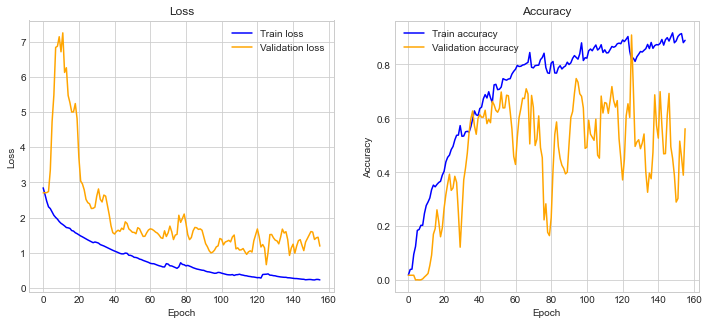

Train set predictions:
              precision    recall  f1-score   support

           0      0.978     0.820     0.892    221802
           1      0.492     0.302     0.374       288
           2      0.453     1.000     0.623        67
           3      0.430     0.430     0.430       542
           4      1.000     0.000     0.000        79
           5      0.398     0.312     0.350      1401
           6      0.147     0.623     0.238       223
           7      0.261     0.726     0.384       500
           8      0.121     0.943     0.215      1072
           9      0.210     0.877     0.339      3793
          10      0.229     0.764     0.353      2803
          11      0.253     0.525     0.342       404
          12      0.357     0.573     0.440       487
          13      0.047     0.305     0.081      1393
          14      0.531     0.973     0.687       451

    accuracy                          0.812    235305
   macro avg      0.394     0.612     0.383    235305
wei

In [28]:
# configuration
LEARNING_RATE = 0.001
MAX_EPOCHS = 200
PATIENCE = 30

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# deterministic
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

# define train transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomPerspective()
])

# create datasets and loaders
train_dataset = HyRANKDatasetTrain(loukia_x.reshape(1, *loukia_x.shape), loukia_y.reshape(1, *loukia_y.shape), transform=transform)
val_dataset = HyRANKDatasetTrain(dioni_x.reshape(1, *dioni_x.shape), dioni_y.reshape(1, *dioni_y.shape), transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset)
val_loader = DataLoader(val_dataset)

# find class weights
classes, counts = np.unique(loukia_y, return_counts=True)
class_weights = 1 - counts / np.sum(counts)
print(class_weights)
class_weights = torch.FloatTensor(class_weights).to(device)

# print some info
train_images, train_labels = next(iter(train_loader))
print(f"Images batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print("Device:", device)

# initialize model
model = UNet(loukia_x.shape[-1], 15)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

 # train
start = time.time()
history = fit(model, train_loader, val_loader, optimizer=optimizer, class_weights=class_weights, 
              checkpoint_name='cnn.pt', max_epochs=MAX_EPOCHS, patience=PATIENCE, device=device)
end = time.time()
print("Training time:", calculate_time_span(start, end))

#  predict validation set
model = UNet(loukia_x.shape[-1], 15)
model.load_state_dict(torch.load('cnn.pt'))  # load best model
y_test, y_pred = predict(model, val_loader, device)

# show results
print('Validation set predictions:')
show_results(y_test, y_pred, history)
    

# predict train set 
y_test, y_pred = predict(model, train_loader, device)

# show results
print('Train set predictions:')
show_results(y_test, y_pred)

Φαίνεται πως το δίκτυο έχει κάνει overfit στην εικόνα του training και επίσης, το επηρεάζει πολύ αρνητικά το γεγονός ότι η πλειοψηφία των pixels είναι unlabeled (κλάση 0). 

Πειραματίστηκα με data augmentation, αλλά τελικά δεν το χρησιμοποίησα καθώς με τη χρήση του το πρόβλημα των imbalanced κλάσεων χειροτέρευε πολύ σε σημείο που μόνο η κλάση 0 (δηλαδή τα unlabeled pixels) προβλέπονταν σωστά. Από την άλλη πειραματίστηκα να αγνοώ αυτή την κλάση είτε θέτοντας την παράμετρο ignore_index=0 στη loss function είτε θέτοντας το βάρος της κλάσης ίσο με το 0, αλλά τότε το δίκτυο δεν φαινόταν ικανό να μάθει.

### Predict test set

Τέλος, με το εκπαιδευμένο μοντέλο κάνω πρόβλεψη στις 3 εικόνες του σετ ελέγχου.

Image shape: (241, 1632, 176)


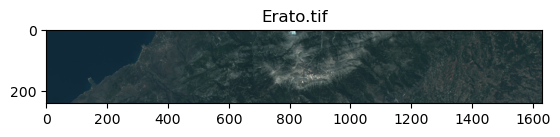

Image shape: (245, 1626, 176)


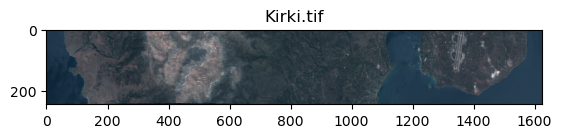

Image shape: (249, 772, 176)


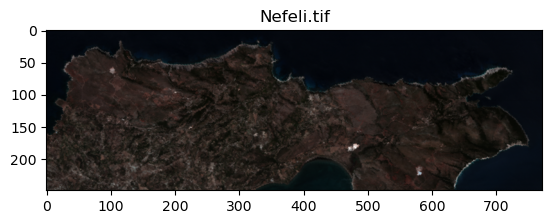

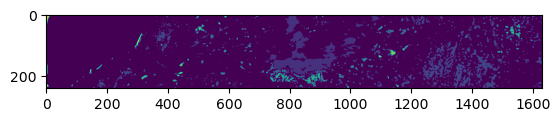

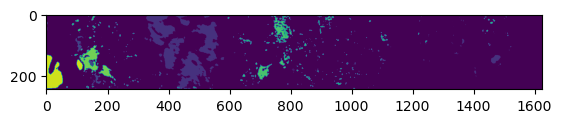

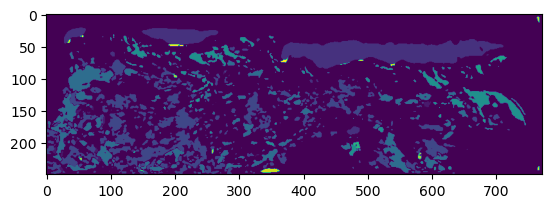

In [37]:
# load validation images
plt.style.use('default')

erato, _ = load_image('HyRANK_satellite/ValidationSet/Erato.tif')
kirki, _ = load_image('HyRANK_satellite/ValidationSet/Kirki.tif')
nefeli, _ = load_image('HyRANK_satellite/ValidationSet/Nefeli.tif')

# create datasets, loaders and predict
for img, name in zip([erato, kirki, nefeli], ['Erato_pred.tif', 'Kirki_pred.tif', 'Nefeli_pred.tif']):
    test_dataset = HyRANKDatasetTest(img.reshape(1, *img.shape), transform=transforms.ToTensor())
    test_loader = DataLoader(test_dataset)

    #  predict
    y_pred = predict_unlabeled(model, test_loader, device)

    plt.figure()
    plt.imshow(y_pred[0])
    plt.show()
    im = Image.fromarray(y_pred[0].astype(np.uint8))
    im.save(name)